In [8]:
import numpy as np
import gsd.hoomd

import multiprocessing as mp
import freud
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import sys

In [44]:
N = 1000
def get_position(args):
    data, frame = args
    return data[frame].particles.position[:]

def load_conformations(gsd_file):
    with gsd_file as data:
        print('#data =', len(data))
        print(filename)
        with mp.Pool(processes=mp.cpu_count()) as pool:
            conf = pool.map(
                get_position,
                [(data, frame) for frame in range(len(data))]
                )
    return np.array(conf)

from scipy.special import erfc

def M2(t, gamma2, tau, J):
    term1 = 2 * gamma2 * np.sqrt(t) * (1 - np.exp(-tau / (np.pi * t)))
    term2 = 2 * J * erfc(np.sqrt(tau / (np.pi * t)))
    return term1 + term2

import numpy as np

def unwrap_pbc(trajectory, L):
    """
    Unwraps a trajectory with periodic boundary conditions (PBC) into free space coordinates.
    
    Parameters:
    trajectory (np.array): The trajectory data of shape [time, number of monomers, spatial axis (3)].
    L (float): The length of the simulation box.

    Returns:
    np.array: Unwrapped trajectory.
    """
    # Copy the trajectory to avoid modifying the original data
    unwrapped_trajectory = np.copy(trajectory)
    
    # Calculate the differences between consecutive time steps
    deltas = np.diff(trajectory, axis=0)
    
    # Apply PBC corrections
    deltas[deltas > L / 2] -= L
    deltas[deltas < -L / 2] += L
    
    # Cumulatively sum the deltas to get the unwrapped positions
    unwrapped_trajectory[1:] = np.cumsum(deltas, axis=0) + trajectory[0]
    
    return unwrapped_trajectory

filename = f'data/with_extrusion/trajectory_extrusion_N1000_proc200_NLEF1_period2600_Nframes10000_0.gsd'



gsd_file = gsd.hoomd.open(name=filename, mode='r')

L = gsd_file[0].configuration.box[0]
period = gsd_file[1].configuration.step - gsd_file[0].configuration.step

# frames = unwrap_pbc(load_conformations(gsd_file), L)
frames = load_conformations(gsd_file)
T = frames.shape[-3]
Nframes = frames.shape[-3]
dt = 0.05
time_simulation = np.linspace(0, period*Nframes*dt, Nframes)

#data = 10000
data/with_extrusion/trajectory_extrusion_N1000_proc200_NLEF1_period2600_Nframes10000_0.gsd


In [20]:
def compute_msd(trajectories):
    gsd_file = gsd.hoomd.open(name=filename, mode='r')
    Lx, Ly, Lz = gsd_file[0].configuration.box[0], gsd_file[0].configuration.box[1], gsd_file[0].configuration.box[2]
    box = freud.box.Box(Lx=Lx, Ly=Ly, Lz=Lz)
    msd = freud.msd.MSD(box=box, mode='window')
    print('computing MSD for')
    msd.compute(trajectories)
    return msd.msd

In [21]:
s = np.array([179, 360, 542, 363, 473, 543])
r = np.array([None, None, 0.8, 0.7, 0.73, None])
tau_auxin = np.array([None, None, 45, 27.5, 22.5, None])
tau_WT = np.array([None, None, 25.5, 18.5, 17, None])

s = np.array([363, 473, 542])
r = np.array([0.7, 0.73, 0.8])
tau_auxin = np.array([27.5, 22.5, 35])
tau_WT = np.array([18.5, 17, 25.5])

# rescaling the bond size to 30nm

In [22]:
# rescaling the bond size to 30nm | Doesn't work | r_ij(300) = 1.3

frames_normalized = frames / np.linalg.norm(np.diff(frames, axis =1), axis=2).mean(axis = 0).mean(axis = 0)

# normalize all bond lengths to 1
# rij_normalized = rij / np.linalg.norm(np.diff(rij, axis =1), axis=2).mean(axis = 1)[:,None,None] 

# # set all bonds legths to 30nm
# frames_scaled = frames_normalized * 0.03
print('check bond size (micro m)' , np.linalg.norm(np.diff(frames_normalized, axis =1), axis=2).mean(axis = 1).mean(axis = 0))
# # print('check r_ij(300)', np.linalg.norm(frames_scaled[:,300] - frames_scaled[:,600], axis = 1).mean())

check bond size (micro m) 0.9999999


# rescaling the bond size to match r(s)

In [23]:
rs = compute_msd(np.swapaxes(frames, 0, 1))

computing MSD for


/tmp/ipykernel_136366/2724911714.py:5: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(np.arange(len(rs))/kb_scale)[1:][w1:w2]
/tmp/ipykernel_136366/2724911714.py:6: RuntimeWarning: invalid value encountered in log10
  y = np.log10(rs/length_scale**2)[1:][w1:w2]


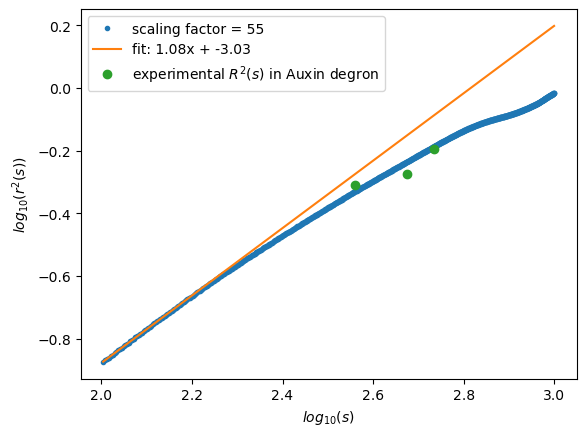

In [28]:
kb_scale = 1
length_scale = 55

w1, w2 = 100, -1
x = np.log10(np.arange(len(rs))/kb_scale)[1:][w1:w2]
y = np.log10(rs/length_scale**2)[1:][w1:w2]
#fit x,y to linear function
p,q = 0, 50
param, pcov = np.polyfit(x[p:q], y[p:q], 1, cov=True)

plt.plot(x,y, '.', label = f'scaling factor = {length_scale}')
plt.plot(x, param[0]*x + param[1], label = f'fit: {param[0]:.2f}x + {param[1]:.2f}')
plt.plot(np.log10(s), np.log10(r**2), 'o', label = r'experimental $R^2(s)$ in Auxin degron')
plt.xlabel(r'$log_{10}(s)$')
plt.ylabel(r'$log_{10}(r^2(s))$')
plt.legend()



In [29]:
rs_scaled = rs / length_scale**2
genomic_coordinates = np.arange(len(rs))/kb_scale
#rescaling the simulation by the fitted scaling factor
frames_scaled = frames_normalized/(length_scale)
print('check bond size (micro m)' , np.linalg.norm(np.diff(frames_scaled, axis =1), axis=2).mean(axis = 1).mean(axis = 0))
print(f'1 monomer represents {round(1/kb_scale, 2)}kb and has size {round(((rs_scaled[1])**0.5)*1000)} nm')
b = np.linalg.norm(np.diff(frames_scaled, axis =1), axis=2).mean(axis = 1).mean(axis = 0)
print(f'end to end dist of 10kb probes = {(rs_scaled[10]**0.5)*1000} nm')
print(f'whole polymer length = {genomic_coordinates[-1]} kb')

check bond size (micro m) 0.018181818
1 monomer represents 1.0kb and has size 19 nm
end to end dist of 10kb probes = 88.678539651956 nm
whole polymer length = 999.0 kb


# scale time against 1 locus MSD

In [30]:
MSD = compute_msd(frames_scaled)

computing MSD for


/tmp/ipykernel_136366/2487262547.py:8: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(time_simulation/time_scale)[1:]


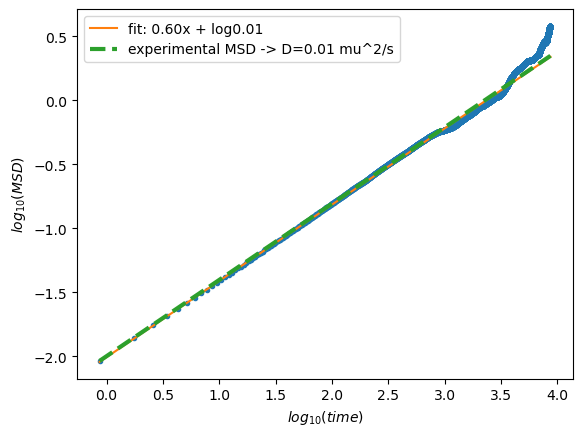

In [32]:
# Experimantal D is approx 0.01 um^2/s

# single monomer MSD

time_scale = 150

y = np.log10(MSD)[1:]
x = np.log10(time_simulation/time_scale)[1:]

p,q = 0, 50

param, pcov = np.polyfit(x[p:q], y[p:q], 1, cov=True)
plt.plot(x,y, '.')
plt.plot(x, param[0]*x + param[1], label = f'fit: {param[0]:.2f}x + log{np.power(10, param[1]):.2f}')
plt.plot(x, param[0]*x + np.log10(0.01), '--', label = f'experimental MSD -> D=0.01 mu^2/s', linewidth = 3)
plt.xlabel(r'$log_{10}(time)$')
plt.ylabel(r'$log_{10}(MSD)$')

plt.legend()

In [33]:
time = time_simulation/time_scale
dt = time[1] - time[0]

In [34]:
print('dt =', dt, 's', 'total time =', round(time[-1]/60), 'min  |  ',  round(time[-1]/3600), 'hours')
print('1s = ', round(period/dt), 'frames')

dt = 0.8667533420008667 s total time = 144 min  |   2 hours
1s =  3000 frames


In [35]:
period

2600

# two locus  MSD

In [36]:
r, s, tau_auxin

(array([0.7 , 0.73, 0.8 ]), array([363, 473, 542]), array([27.5, 22.5, 35. ]))

computing MSD for
computing MSD for
computing MSD for


/tmp/ipykernel_136366/2222369614.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/tmp/ipykernel_136366/2222369614.py:15: RuntimeWarning: invalid value encountered in log10
  y = np.log10(MSD_two_k)[1:]
/tmp/ipykernel_136366/2222369614.py:16: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(time)[1:]


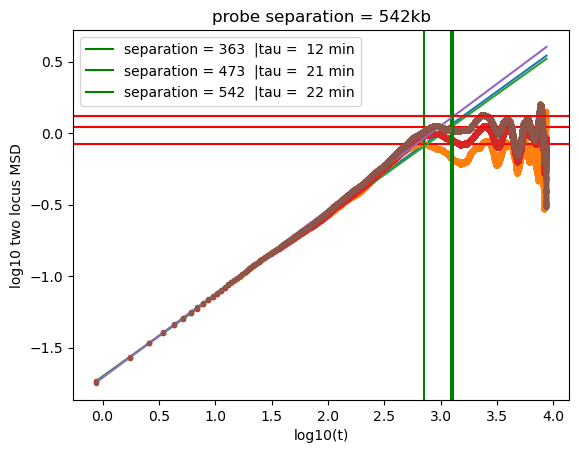

In [37]:
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')
colors = [cmap(0.2), cmap(0.5), cmap(0.8)]

for separation in s:
    N = frames.shape[1]
    probe_position_1 = 200
    probe_position_2 = probe_position_1 + separation
    separation = probe_position_2 - probe_position_1
    # rij = np.array([(frames_scaled[:,i,:] - frames_scaled[:,i+k,:]) for i in np.linspace(k,N-k-1, (np.floor(N/k)).astype(int)).astype(int)])
    rij = np.array([frames_scaled[:,probe_position_1+5,:] - frames_scaled[:,probe_position_2+5,:]]) 
    rij = np.swapaxes(np.array(rij), 0,1)
    rij_k = (np.linalg.norm(rij, axis = -1)**2).mean(axis=0).mean()
    MSD_two_k = compute_msd(rij)
    y = np.log10(MSD_two_k)[1:]
    x = np.log10(time)[1:]

    p,q = 0, 10

    param, pcov = np.polyfit(x[p:q], y[p:q], 1, cov=True)
    D = np.power(10,param[1])
    alpha = param[0]
    plt.plot(x, param[0]*x + param[1])

    # p,q = 0, 100
    # param, pcov = curve_fit(M2, np.exp(x)[p:q], np.exp(y)[p:q], p0=[0.01, 10, 1])
    # plt.plot(x, np.log10(M2(np.exp(x), *param)), label = f'fit: D: {param[0]:.2f} | tau: {param[1]:.2f} | rij^2: {param[2]:.2f}')

    tau = (2*rij_k/D)**(1/alpha)
    plt.plot(x,y, '.')
    plt.axhline(np.log10(2*(rij_k)), color='r')
    plt.axvline(np.log10(tau), label  = f'separation = {separation}  |' + f'tau =  {round(tau/60)} min', color='g')
    plt.xlabel('log10(t)')
    plt.ylabel('log10 two locus MSD')
    plt.title(f'probe separation = {separation}kb')
    plt.legend()



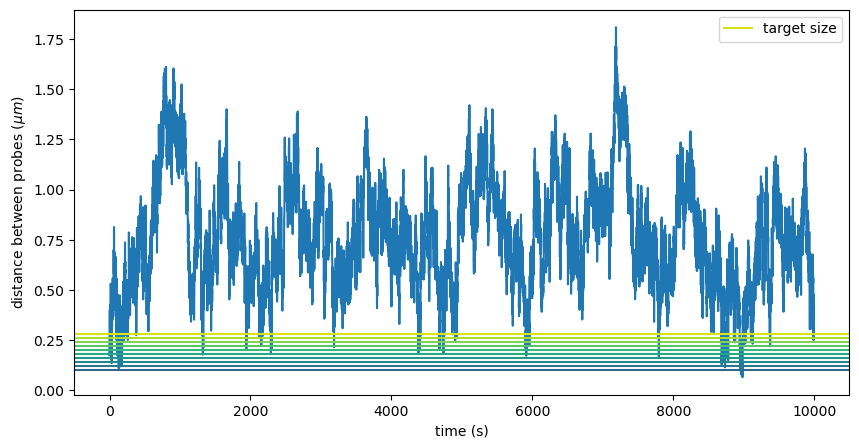

In [39]:
# plot the target sizes and the distance between the two probes over time with a color map for the target sizes
target_sizes = np.linspace(0.1, 0.3, 100)

plt.figure(figsize=(10,5))


norm_rij = np.linalg.norm(rij[:,0,:], axis = -1)
w1, w2 = 0, -1
plt.plot( norm_rij[w1:w2])
cmap = plt.get_cmap('viridis')
for target_size in target_sizes[::10]:
    plt.axhline(target_size, color = cmap(target_size/max(target_sizes)))
plt.axhline(target_size, color = cmap(target_size/max(target_sizes)), label = 'target size')
plt.xlabel('time (s)')
plt.ylabel(r'distance between probes ($\mu m$)')
plt.legend()
plt.show()

363
8315.858224319896
473
8315.858224319896
542
8315.858224319896


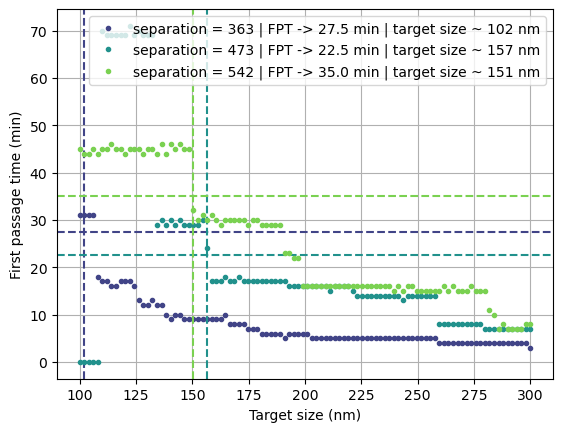

In [48]:
def find_closest(array, a):
    differences = np.abs(array - a)
    idx = np.argmin(differences)
    closest_value = array[idx]
    return idx

k=360
for sth, separation in enumerate(s):
    print(separation)
    rij = np.array([(frames_scaled[:,i,:] - frames_scaled[:,i+k,:]) for i in np.linspace(k,N-k-1, (np.floor(N/k)).astype(int)).astype(int)])
    probe_position_1 = 300
    probe_position_2 = probe_position_1 + separation
    # separation = probe_position_2 - probe_position_1
    rij = np.array([frames_scaled[:,probe_position_1+5,:] - frames_scaled[:,probe_position_2+5,:]]) 
    rij = np.swapaxes(np.array(rij), 0,1)
    norm_rij = np.linalg.norm(rij[:,0,:], axis = -1)
    tau = (2*rij_k/D)**(1/alpha)
    fpts_means = []
    print(tau)
    for target_size in target_sizes:
        fpts = []
        for k in range(5000):
            t = np.random.randint(0, T)
            rij_conditionned = norm_rij[t::1]
            if norm_rij[t]>target_size:
                fpts.append(time[np.argmax(rij_conditionned < target_size)])
        fpts_means.append(np.mean(fpts))
    fpts_means = np.array(fpts_means) 

    # fit a power law to the data
    def power_law(x, a, b, c):
        return a*x**b + c

    x = target_sizes*1000
    y = np.round((fpts_means/60))

    # popt, pcov = curve_fit(power_law, x, y, p0=[1, -2, 1])
    # plt.plot(x, power_law(x, *popt), label=f'fit: {popt[0]:.4f}x^{popt[1]:.2f} + {popt[2]:.2f}')
    plt.ylabel('First passage time (min)')
    plt.xlabel('Target size (nm)')
    opt_size = target_sizes[find_closest(fpts_means/60, tau_auxin[sth])]*1000
    plt.plot(x, y, '.', label=f'separation = {separation} | FPT -> {tau_auxin[sth]} min | target size ~ {round(opt_size)} nm', color = colors[sth])
    plt.axhline(tau_auxin[sth], color=colors[sth], linestyle='--')
    plt.axvline(opt_size, linestyle = '--', color = colors[sth])
    
    plt.grid()
    plt.legend()

In [41]:
def find_closest(array, a):
    differences = np.abs(array - a)
    idx = np.argmin(differences)
    closest_value = array[idx]
    return idx

for sth, separation in enumerate(s):
    print(separation)
    rij = np.array([(frames_scaled[:,i,:] - frames_scaled[:,i+k,:]) for i in np.linspace(k,N-k-1, (np.floor(N/k)).astype(int)).astype(int)])
    probe_position_1 = 300
    probe_position_2 = probe_position_1 + separation
    # separation = probe_position_2 - probe_position_1
    rij = np.array([frames_scaled[:,probe_position_1+5,:] - frames_scaled[:,probe_position_2+5,:]]) 
    rij = np.swapaxes(np.array(rij), 0,1)
    norm_rij = np.linalg.norm(rij[:,0,:], axis = -1)
    tau = (2*rij_k/D)**(1/alpha)
    fpts_means = []
    print(tau)
    for target_size in target_sizes:
        fpts = []
        for k in range(5000):
            t = np.random.randint(0, 49_000)
            rij_conditionned = norm_rij[t::1]
            if norm_rij[t]>target_size:
                fpts.append(time[np.argmax(rij_conditionned < target_size)])
        fpts_means.append(np.mean(fpts))
    fpts_means = np.array(fpts_means) 

    # fit a power law to the data
    def power_law(x, a, b, c):
        return a*x**b + c

    x = target_sizes*1000
    y = np.round((fpts_means/60))

    # popt, pcov = curve_fit(power_law, x, y, p0=[1, -2, 1])
    # plt.plot(x, power_law(x, *popt), label=f'fit: {popt[0]:.4f}x^{popt[1]:.2f} + {popt[2]:.2f}')
    plt.ylabel('First passage time (min)')
    plt.xlabel('Target size (nm)')
    plt.plot(x, y, '.', label=f'separation = {separation} | FPT -> {tau_auxin[sth]} min | target size ~ {round(opt_size)} nm', color = colors[sth])
    plt.axhline(tau_auxin[sth], color=colors[sth], linestyle='--')
    opt_size = target_sizes[find_closest(fpts_means/60, tau_auxin[sth])]*1000
    plt.axvline(opt_size, linestyle = '--', color = colors[sth])
    
    plt.grid()
    plt.legend()

363


NameError: name 'k' is not defined

In [372]:
25.5*35/(35-25.5)

93.94736842105263

In [373]:
target_sizes[find_closest(fpts_means/60, tau_auxin[sth])]*1000

100.0

In [247]:
tau_auxin[sth]

22.5

In [ ]:
target_sizes[find_closest(fpts, tau_auxin[sth])]

In [146]:
print(s, tau_auxin)

[542 363 473] [45.  27.5 22.5]


120.53418159908347
598.9968526742829
2374.5804525121007
8315.858224319896


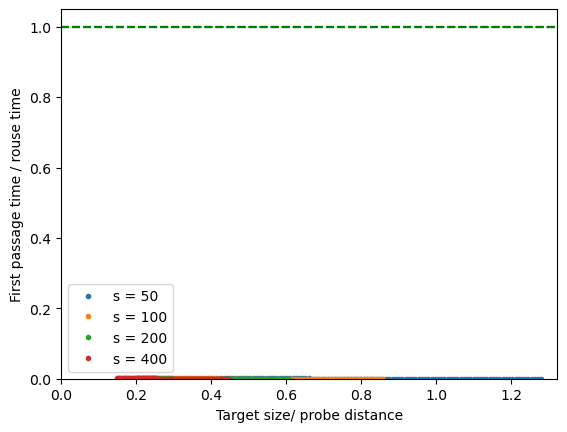

In [46]:
separation = 400
for separation in [50, 100, 200, 400]:
    probe_position_1 = 200
    probe_position_2 = probe_position_1 + separation
    # separation = probe_position_2 - probe_position_1
    # rij = np.array([(frames_scaled[:,i,:] - frames_scaled[:,i+k,:]) for i in np.linspace(k,N-k-1, (np.floor(N/k)).astype(int)).astype(int)])
    rij = np.array([frames_scaled[:,probe_position_1+5,:] - frames_scaled[:,probe_position_2+5,:]]) 
    rij_k = (np.linalg.norm(rij, axis = -1)**2).mean(axis=0).mean()
    rij = np.swapaxes(np.array(rij), 0,1)
    norm_rij = np.linalg.norm(rij[:,0,:], axis = -1)

    fpts_means = []
    for target_size in target_sizes:
        fpts = []
        for k in range(2000):
            t = np.random.randint(0, T)
            rij_conditionned = norm_rij[t:]
            if norm_rij[t]>target_size:
                fpts.append(np.argmax(rij_conditionned < target_size))
        fpts_means.append(np.mean(fpts)/time_scale)
    fpts_means = np.array(fpts_means) 
    

    # fit a power law to the data
    def power_law(x, a, b, c):
        return a*x**b + c

    x = (target_sizes)/(rij_k**0.5)
    D = 0.01
    alpha = 0.5
    #/np.sqrt(separation)
    tau = ((2*rij_k/D)**2)
    print(tau)
    y = (fpts_means/tau)

    # popt, pcov = curve_fit(power_law, x, y, p0=[1, -2, 1])
    # plt.plot(x, power_law(x, *popt), label=f'fit: {popt[0]:.4f}x^{popt[1]:.2f} + {popt[2]:.2f}')
    plt.ylabel('First passage time / rouse time')
    plt.xlabel('Target size/ probe distance')
    plt.plot(x, y, '.', label=f's = {separation}')
    # plt.axhline(popt[2], color='r', linestyle='--', label=f'asymptotic value : {popt[2]:.2f}')
    plt.axhline(1, linestyle = '--', color='g')
    plt.ylim(0)
    plt.xlim(0)
    plt.grid()
    plt.legend()

In [28]:
fpts_means = []
for target_size in [0.12]:
    fpts = []
    for k in range(2000):
        t = np.random.randint(0, 49_000)
        rij_conditionned = norm_rij[t:]
        if norm_rij[t]>target_size:
            fpts.append(np.argmax(rij_conditionned < target_size))
    fpts_means.append(np.mean(fpts)/time_scale)
fpts_means = np.array(fpts_means) 

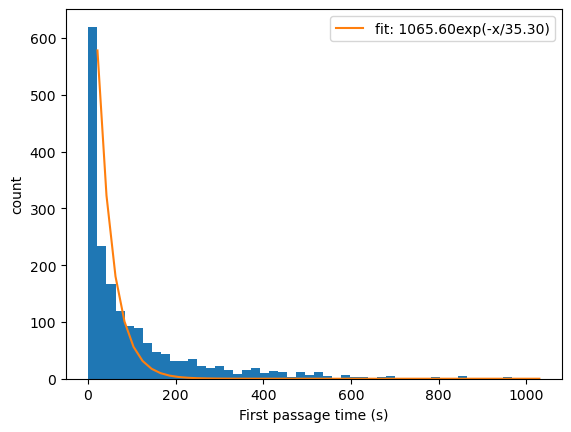

In [178]:
#fit the histogram of passage times with an exponential distribution
def exp_dist(x, a, b):
    return a*np.exp(-b*x)
h = plt.hist(fpts, bins = 50)
popt, pcov = curve_fit(exp_dist, h[1][1:], h[0], p0=[1, 0.01])
plt.plot(h[1][1:], exp_dist(h[1][1:], *popt), label=f'fit: {popt[0]:.2f}exp(-x/{1/popt[1]:.2f})')
plt.xlabel('First passage time (s)')
plt.ylabel('count')
plt.legend()